<a href="https://colab.research.google.com/github/Savith-02/notebooks/blob/main/rnn_intent_classifier/rnn_intent_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
def read_dataset(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            intent, sentence = line.strip().split(',')
            data.append((intent.strip(), sentence.strip()))
    return data

# Example usage
file_path = "data.txt"  # Replace with the path to your dataset file
dataset = read_dataset(file_path)
print(dataset[:10])

[('Intent', 'Example'), ('Greet', 'Hi'), ('Greet', 'Hello'), ('Greet', 'Hey there'), ('Greet', 'Good morning'), ('Greet', 'Howdy'), ('Greet', 'Hi there'), ('Greet', 'Hey'), ('Greet', 'Good afternoon'), ('Greet', 'Hello there')]


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


# Define the vocabulary
all_chars = set(''.join([sentence for intent, sentence in dataset]))
char_to_index = {char: i for i, char in enumerate(all_chars)}
index_to_char = {i: char for char, i in char_to_index.items()}
num_chars = len(all_chars)

all_intents = set(intent for intent, _ in dataset)
intent_to_index = {intent: i for i, intent in enumerate(all_intents)}
index_to_intent = {i: intent for intent, i in intent_to_index.items()}
num_intents = len(all_intents)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Convert sentences to tensors
def sentence_to_tensor(sentence):
    tensor = torch.zeros(len(sentence), 1, num_chars).to(device)
    for i, char in enumerate(sentence):
        tensor[i][0][char_to_index[char]] = 1
    return tensor

# Convert intents to tensors
def intent_to_tensor(intent):
    return torch.tensor([intent_to_index[intent]], dtype=torch.long).to(device)

# Define the RNN model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        hidden = self.init_hidden()
        output, _ = self.rnn(input, hidden)
        output = self.fc(output[-1])
        output = self.softmax(output)
        return output

    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size).to(device)

In [4]:
# optim.lr_scheduler.ExponentialLR
import torch.optim as optim


Epoch 10/100, Loss: 609.4816315770149
Epoch 20/100, Loss: 492.07849913835526
Epoch 30/100, Loss: 406.62749806046486
Epoch 40/100, Loss: 369.9298486560583
Epoch 50/100, Loss: 354.3457619100809
Epoch 60/100, Loss: 348.2751483693719
Epoch 70/100, Loss: 346.05471117794514
Epoch 80/100, Loss: 345.26703537255526
Epoch 90/100, Loss: 344.9907504618168
Epoch 100/100, Loss: 344.8937763273716


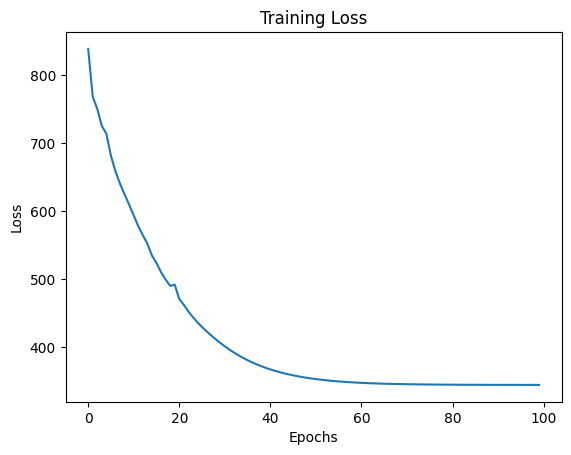

In [6]:
# Define hyperparameters
hidden_size = 128
learning_rate = 0.001
epochs = 100

# Initialize the model
model = RNN(num_chars, hidden_size, num_intents)
model.to(device)

loss_function = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# Training loop with loss plotting
losses = []
for epoch in range(epochs):
    total_loss = 0
    for intent, sentence in dataset:
        model.zero_grad()
        intent_tensor = intent_to_tensor(intent)
        sentence_tensor = sentence_to_tensor(sentence)
        output = model(sentence_tensor)
        loss = loss_function(output, intent_tensor)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    scheduler.step()
    losses.append(total_loss)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss}")

# Plot the loss
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


In [9]:

def train_rnn(model, training_data, cv_data, intent_to_tensor, sentence_to_tensor, device, hidden_size, learning_rate, epochs):

    # Initialize the model
    model = model(num_chars, hidden_size, num_intents)
    model.to(device)

    loss_function = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

    # Training loop with loss plotting
    losses = []
    cv_losses = []
    training_dataset_len = len(training_data)
    cv_dataset_len = len(cv_data)

    for epoch in range(epochs):
        total_loss = 0

        for intent, sentence in training_data:
            model.zero_grad()
            intent_tensor = intent_to_tensor(intent)
            sentence_tensor = sentence_to_tensor(sentence)
            output = model(sentence_tensor)
            loss = loss_function(output, intent_tensor)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        scheduler.step()
        losses.append(total_loss / training_dataset_len)
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss}")

        total_cv_loss = 0
        with torch.no_grad():
          for intent, sentence in cv_data:
              intent_tensor = intent_to_tensor(intent)
              sentence_tensor = sentence_to_tensor(sentence)
              output = model(sentence_tensor)
              loss = loss_function(output, intent_tensor)
              total_cv_loss += loss.item()

          cv_losses.append(total_cv_loss / cv_dataset_len)

    # Plot the loss
    # plt.plot(losses)
    # plt.xlabel('Epochs')
    # plt.ylabel('Loss')
    # plt.title('Training Loss')
    # plt.show()

    return losses, cv_losses

In [12]:
losses_container = []
learning_rates = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3]
num = len(learning_rates)

split = round(len(dataset) * 60 / 100)
training_data = dataset[:split]
cv_data = dataset[split:]

for i in range(num):
  loss_arr, cv_loss_arr = train_rnn(
    model=RNN,
    training_data=training_data,
    cv_data=cv_data,
    intent_to_tensor=intent_to_tensor,
    sentence_to_tensor=sentence_to_tensor,
    device=device,
    hidden_size=128,
    learning_rate=learning_rates[i],
    epochs=100
  )
  losses_container.append([loss_arr, cv_loss_arr])


Epoch 10/100, Loss: 359.43366944789886
Epoch 20/100, Loss: 307.0359653234482
Epoch 30/100, Loss: 270.47982066869736
Epoch 40/100, Loss: 253.80370411276817
Epoch 50/100, Loss: 247.25995993614197
Epoch 60/100, Loss: 244.98611789941788
Epoch 70/100, Loss: 244.18739566206932
Epoch 80/100, Loss: 243.9084362089634
Epoch 90/100, Loss: 243.81138828396797
Epoch 100/100, Loss: 243.7776814699173
Epoch 10/100, Loss: 355.44701662659645
Epoch 20/100, Loss: 304.07671105861664
Epoch 30/100, Loss: 242.23988430947065
Epoch 40/100, Loss: 210.5313964486122
Epoch 50/100, Loss: 199.49611361324787
Epoch 60/100, Loss: 195.10892737656832
Epoch 70/100, Loss: 193.51792491972446
Epoch 80/100, Loss: 192.90834176540375
Epoch 90/100, Loss: 192.68312540650368
Epoch 100/100, Loss: 192.6033897548914
Epoch 10/100, Loss: 554.193948129192
Epoch 20/100, Loss: 401.68520468473434
Epoch 30/100, Loss: 345.29408517852426
Epoch 40/100, Loss: 323.27613995037973
Epoch 50/100, Loss: 313.29326421394944
Epoch 60/100, Loss: 309.769930

In [16]:
len(losses_container)

6

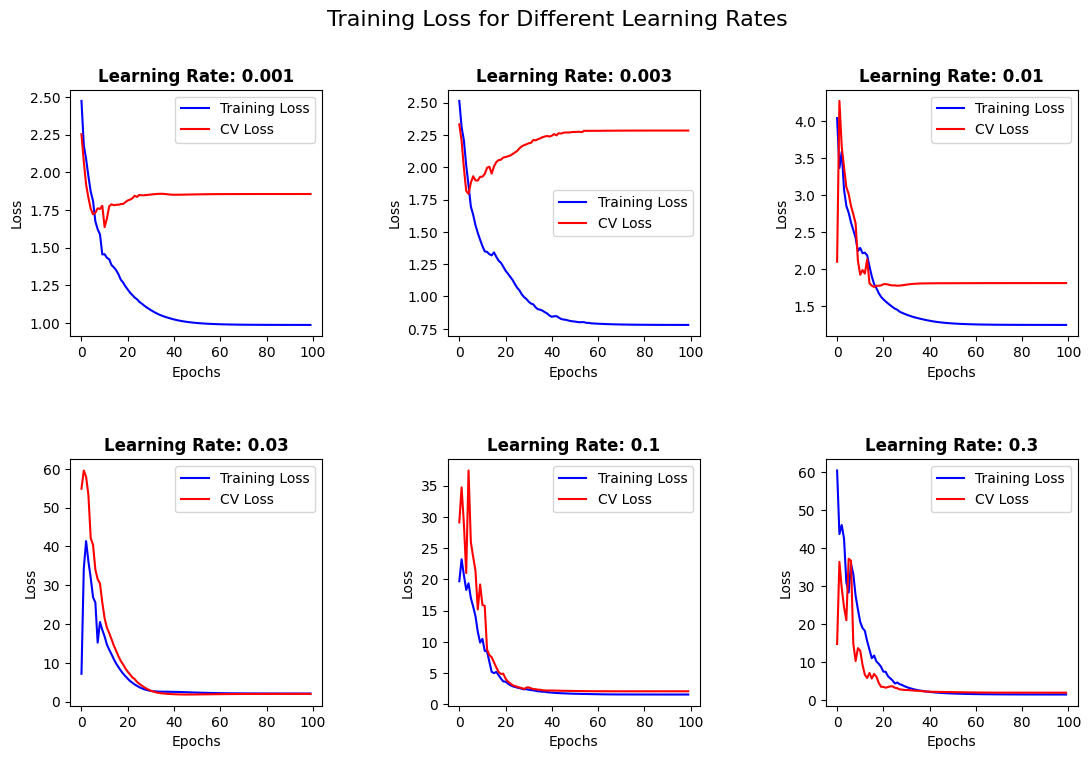

In [17]:
fig, ax = plt.subplots(2, 3, figsize=(13, 8))
fig.suptitle('Training Loss for Different Learning Rates', fontsize=16)

for i in range(2):
    for j in range(3):
        ax[i][j].plot(losses_container[i * 3 + j][0], label='Training Loss', color='b')
        ax[i][j].plot(losses_container[i * 3 + j][1], label='CV Loss', color='r')
        ax[i][j].set_title(f'Learning Rate: {learning_rates[i * 3 + j]}', fontsize=12, fontweight='bold')
        ax[i][j].set_xlabel('Epochs')
        ax[i][j].set_ylabel('Loss')
        ax[i][j].legend()

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

In [18]:
# Test the model
def predict_intent(sentence):
    with torch.no_grad():
        output = model(sentence_to_tensor(sentence))
        _, predicted_index = torch.max(output, 1)
        predicted_intent = index_to_intent[predicted_index.item()]
        return predicted_intent

# Example usage
test_sentence = "How are you?"
print("Predicted intent:", predict_intent(test_sentence))

Predicted intent: Navigation


In [ ]:
# all_intents

In [ ]:
# char_to_index.items()

dict_items([('l', 0), ('R', 1), ('q', 2), ('m', 3), ('B', 4), ('U', 5), ('C', 6), ('w', 7), ('e', 8), ('o', 9), ('h', 10), ('p', 11), ('T', 12), ('v', 13), ('L', 14), ('F', 15), ('n', 16), ('S', 17), ('P', 18), ('-', 19), ('b', 20), ('i', 21), ('G', 22), ('2', 23), ('.', 24), ('u', 25), ('g', 26), ('j', 27), ('c', 28), ('E', 29), ('W', 30), ('x', 31), ('N', 32), ('f', 33), ('O', 34), ('r', 35), ('z', 36), ('a', 37), ('t', 38), ('k', 39), ('?', 40), (' ', 41), ('y', 42), ('Y', 43), ('I', 44), ('s', 45), ('7', 46), ('H', 47), ('A', 48), ('"', 49), ("'", 50), ('d', 51), ('M', 52), ('!', 53)])

In [20]:
loss_arr, cv_arr = train_rnn(
    model=RNN,
    training_data=training_data,
    cv_data=cv_data,
    intent_to_tensor=intent_to_tensor,
    sentence_to_tensor=sentence_to_tensor,
    device=device,
    hidden_size=254,
    learning_rate=0.0001,
    epochs=100
  )

Epoch 10/100, Loss: 447.21307015419006
Epoch 20/100, Loss: 387.3270528912544
Epoch 30/100, Loss: 364.4088972210884
Epoch 40/100, Loss: 356.765787422657
Epoch 50/100, Loss: 354.1559662222862
Epoch 60/100, Loss: 353.25317299366
Epoch 70/100, Loss: 352.9393270611763
Epoch 80/100, Loss: 352.8300757408142
Epoch 90/100, Loss: 352.7924454212189
Epoch 100/100, Loss: 352.78058379888535


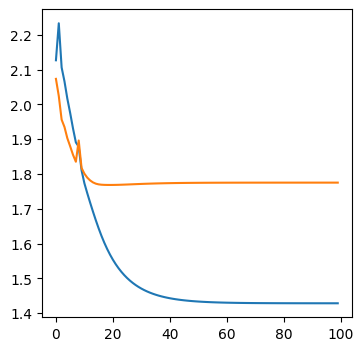

In [21]:
plt.figure(figsize=(4, 4))
plt.plot(loss_arr)
plt.plot(cv_arr)
plt.show()